## Import all the required libraries

In [1]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Subset
from torch.utils.data import Dataset
import time
from torch.utils.tensorboard import SummaryWriter
from tensorboard.notebook import display, start
from torchvision import models

In [2]:
%matplotlib inline

## Set seed for reproducibility of results

In [3]:
torch.manual_seed(42) 
random.seed(42)  
np.random.seed(42) 

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  

## Load Dataset

In [4]:
path_of_datset = "project_dataset_mandava6_rachanad.zip"
extract_the_dataset = "Data"

with zipfile.ZipFile(path_of_datset, 'r') as zip_reference:
    zip_reference.extractall(extract_the_dataset)

## Transform Dataset

In [5]:
transform_dataset = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [6]:
training_dataset_directory = os.path.join(extract_the_dataset, 'Data/train')
testing_dataset_directory = os.path.join(extract_the_dataset, 'Data/test')

In [7]:
dataset = ImageFolder(root=training_dataset_directory, transform=transform_dataset)
testing_dataset = ImageFolder(root=testing_dataset_directory, transform=transform_dataset)

## Preprocess the Dataset

In [8]:
total_number_of_training_images = len(dataset)
print(f"Total Number of Training and Validation Images: {total_number_of_training_images}")

Total Number of Training and Validation Images: 5144


In [9]:
total_number_of_testing_images = len(testing_dataset)
print(f"Total Number of Testing Images: {total_number_of_testing_images}")

Total Number of Testing Images: 1288


In [10]:
names_of_classes =  dataset.classes
print(f"Classes: {names_of_classes}")

Classes: ['COVID19', 'NORMAL', 'PNEUMONIA']


In [11]:
counts_of_class = {names_of_classes[i]: 0 for i in range(len(names_of_classes))}
for _, label in dataset.samples:
    counts_of_class[names_of_classes[label]] = counts_of_class[names_of_classes[label]] + 1

print("Class Distribution in the Dataset:", counts_of_class)

Class Distribution in the Dataset: {'COVID19': 460, 'NORMAL': 1266, 'PNEUMONIA': 3418}


In [12]:
image_sample, _ = dataset[0]
print(f"Shape of the Image: {image_sample.shape}")

Shape of the Image: torch.Size([3, 64, 64])


In [13]:
pixels = []
for image, _ in dataset:
    pixels.append(image.view(3, -1))
pixels = torch.cat(pixels, dim=1)

Main statistics of the dataset

In [14]:
mean_of_image = torch.mean(pixels, dim=1)
std_of_image = torch.std(pixels, dim=1)
min_pixel_of_image = torch.min(pixels)
max_pixel_of_image = torch.max(pixels)

In [15]:
print(f"Mean of the Pixel: {mean_of_image.numpy()}")
print(f"Standard Deviation of the Pixel: {std_of_image.numpy()}")
print(f"Minimum Pixel of Image: {min_pixel_of_image:.4f}") 
print(f"Maximum Pixel of Image: {max_pixel_of_image:.4f}")

Mean of the Pixel: [0.4923709  0.49246326 0.4925521 ]
Standard Deviation of the Pixel: [0.22802506 0.22802255 0.22805242]
Minimum Pixel of Image: 0.0000
Maximum Pixel of Image: 1.0000


In [16]:
data_loader = DataLoader(dataset, batch_size=9, shuffle=True)
images, labels = next(iter(data_loader))

## Visualization-1

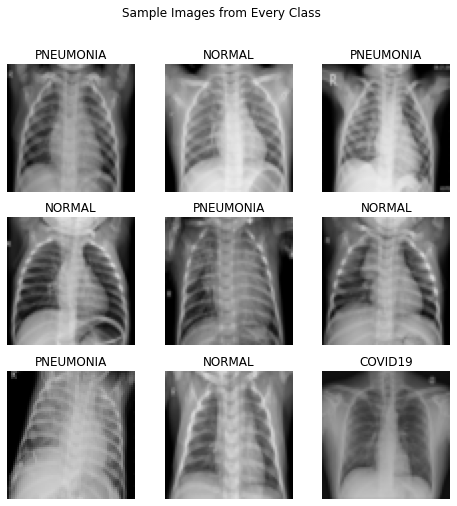

In [17]:
figure, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, axis in enumerate(axes.flat):
    image = images[i].permute(1, 2, 0).numpy()
    axis.imshow(image)
    axis.set_title(names_of_classes[labels[i].item()])
    axis.axis('off')
plt.suptitle("Sample Images from Every Class")
plt.show()

Using matplotlib, the code snippet displays (for example) a 3x3 grid of chest X-ray images. In addition, there are class labels, including PNEUMONIA, NORMAL, and COVID19. The plot will load and format the images using information from the tensor, set titles based on the class labels, and will remove the axis lines to create a succinct and clean visual. Ultimately, the plot plots a visual sample of the data that represent each class to provide insight into the nature of the diversity in each dataset.

## Visualization-2

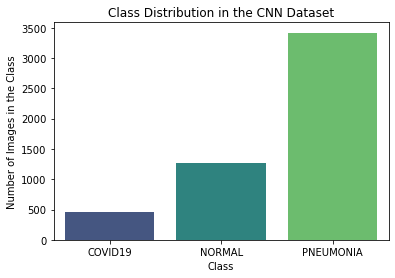

In [18]:
plt.figure(figsize=(6, 4))
sns.barplot(x=list(counts_of_class.keys()), y=list(counts_of_class.values()), palette="viridis")
plt.xlabel("Class")
plt.ylabel("Number of Images in the Class")
plt.title("Class Distribution in the CNN Dataset")
plt.show()

The bar plot displays the class distribution in the CNN dataset for the three categories: COVID19, NORMAL, and PNEUMONIA. There is a large class imbalance in the dataset (PNEUMONIA has the most images followed by NORMAL, then COVID19), which may affect model performance, therefore many times to address this imbalance, you can employ techniques such as class weighting or data augmentation while training your model to make certain the model is trained fairly.

## Visualization-3

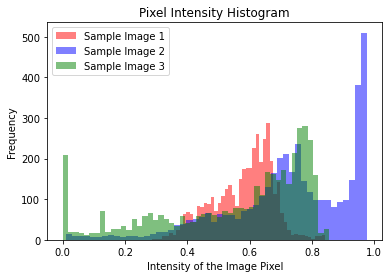

In [19]:
images_sample = [dataset[i][0][0].flatten().numpy() for i in range(3)]
plt.figure(figsize=(6, 4))
plt.hist(images_sample[0], bins=50, alpha=0.5, label="Sample Image 1", color="red")
plt.hist(images_sample[1], bins=50, alpha=0.5, label="Sample Image 2", color="blue")
plt.hist(images_sample[2], bins=50, alpha=0.5, label="Sample Image 3", color="green")
plt.xlabel("Intensity of the Image Pixel")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Histogram")
plt.legend()
plt.show()

The histogram shows distributions of pixel intensity from three grayscale sample images of dataset. The curves show the frequencies of pixel intensity values occurring between 0 (black) and 1 (white). This visualization is useful because it shows the contrast and brightness of each of the images and is helpful in understanding the normalization and pre-processing process.

# Transform Dataset

In [20]:
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_of_image.numpy(), std=std_of_image.numpy())
])

In [21]:
transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_of_image.numpy(), std=std_of_image.numpy())
])

In [22]:
dataset = ImageFolder(root=training_dataset_directory, transform=transform_train)
testing_dataset = ImageFolder(root=testing_dataset_directory, transform=transform_test)

In [23]:
counts_of_each_class = torch.tensor(list(counts_of_class.values()), dtype=torch.float)
weights_of_class = 1.0 / counts_of_each_class
weights_sample = [weights_of_class[label] for _, label in dataset.samples]

In [24]:
weight_random_sampler = WeightedRandomSampler(weights=weights_sample, num_samples=len(weights_sample), replacement=True)

In [25]:
data_loader = DataLoader(dataset, batch_size=32, sampler=weight_random_sampler, collate_fn=lambda batch: (
    torch.stack([image for image, _ in batch]), 
    torch.tensor([label for _, label in batch], dtype=torch.long) 
))

batch_images, batch_labels = next(iter(data_loader))
print(f"Type of Batch label: {batch_labels.dtype}") 
print(f"Batch labels: {batch_labels[:15]}")  


Type of Batch label: torch.int64
Batch labels: tensor([0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 2, 1, 1, 0, 2])


Split the train data into train and validate 

In [26]:
indexes_of_dataset = len(dataset)

training_indices = int(0.6 * indexes_of_dataset)
validation_indices = indexes_of_dataset - training_indices

training_dataset, validation_dataset = random_split(dataset, [training_indices, validation_indices])

In [27]:
print(f"Size of Training set: {len(training_dataset)}")
print(f"Size of Validation set: {len(validation_dataset)}")
print(f"Size of Testing set: {len(testing_dataset)}")

Size of Training set: 3086
Size of Validation set: 2058
Size of Testing set: 1288


## VGG16 Model

In [28]:
class VGG16_Architecture(nn.Module):
    def __init__(self, number_of_classes):
        super(VGG16_Architecture, self).__init__()
        
        self.features = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, number_of_classes) 
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  
        x = self.classifier(x)
        return x

In [29]:
number_of_classes = len(names_of_classes)
vgg16_model = VGG16_Architecture(number_of_classes)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [31]:
vgg16_model = vgg16_model.to(device)
print(vgg16_model)

VGG16_Architecture(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

In [32]:
def weights_initialisation(model, init_type):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if init_type == "xavier":
                nn.init.xavier_uniform_(m.weight)
            elif init_type == "he":
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

Train model function

In [33]:
def train_model(model, training_dataset, validation_dataset, device, type_of_optimizer="SGD", size_of_batch=32, number_of_epochs=5):

    training_loader = DataLoader(training_dataset, batch_size=size_of_batch, shuffle=True, num_workers=1)
    validation_loader = DataLoader(validation_dataset, batch_size=size_of_batch, shuffle=False, num_workers=1, drop_last=False)
    
    loss_function = nn.CrossEntropyLoss()

    if type_of_optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    elif type_of_optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
    elif type_of_optimizer == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=5e-4)

    learning_rate_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    train_validate_data = {"training_loss": [], "validation_loss": [], "training_accuracy": [], "validation_accuracy": []}
    
    for epoch in range(number_of_epochs):
        model.train()
        loss_running = 0.0
        train_correct = 0
        train_total = 0
        start_time = time.time()

        for train_images, train_labels in training_loader:
            train_images = train_images.to(device) 
            train_labels = train_labels.to(device)  

            optimizer.zero_grad()
            train_outputs = model(train_images)
            train_loss = loss_function(train_outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            _, train_predicted = train_outputs.max(1)
            train_correct = train_correct + train_predicted.eq(train_labels).sum().item()
            train_total = train_total + train_labels.size(0)
            loss_running = loss_running + train_loss.item()

        training_loss = loss_running / len(training_loader)
        training_accuracy = train_correct / train_total
        train_validate_data["training_loss"].append(training_loss)
        train_validate_data["training_accuracy"].append(training_accuracy)

        model.eval()
        validation_loss = 0.0 
        validation_correct = 0 
        validation_total = 0
        
        with torch.no_grad():
            for validation_images, validation_labels in validation_loader:
                validation_images = validation_images.to(device) 
                validation_labels = validation_labels.to(device) 
                
                validation_outputs = model(validation_images)
                loss = loss_function(validation_outputs, validation_labels)
                
                _, validation_predicted = validation_outputs.max(1)
                validation_correct = validation_correct + validation_predicted.eq(validation_labels).sum().item()
                validation_total = validation_total + validation_labels.size(0)
                validation_loss = validation_loss + loss.item()
        
        validation_loss = validation_loss / len(validation_loader)
        validation_accuracy = validation_correct / validation_total
        train_validate_data["validation_loss"].append(validation_loss)
        train_validate_data["validation_accuracy"].append(validation_accuracy)

        learning_rate_scheduler.step()  

        print(f"Epoch: [{epoch+1}/{number_of_epochs}] --> Time: {time.time() - start_time:.2f}s --> Training Loss: {training_loss:.4f} --> Training Accuracy: {training_accuracy * 100:.2f} --> Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy * 100:.2f}")
    
    return train_validate_data

Model Evaluation Function

In [34]:
def evaluate_model(model, testing_dataset, train_validate_test_data):
    
    model.eval() 

    test_loader = DataLoader(testing_dataset, batch_size=32, shuffle=False)
    
    loss_function = torch.nn.CrossEntropyLoss()
    
    total_test_loss = 0.0 
    test_correct = 0 
    test_total = 0
    
    all_labels = [] 
    all_predictions = []

    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)
            test_outputs = model(test_images)
            loss = loss_function(test_outputs, test_labels)

            total_test_loss = total_test_loss + loss.item()
            _, test_predicted = test_outputs.max(1)
            test_correct = test_correct + test_predicted.eq(test_labels).sum().item()
            test_total = test_total + test_labels.size(0)

            all_labels.extend(test_labels.cpu().numpy())
            all_predictions.extend(test_predicted.cpu().numpy())

    test_accuracy = test_correct / test_total
    average_test_loss = total_test_loss / len(test_loader)
    precision, recall, f1_score, _ = precision_recall_fscore_support(np.array(all_labels), np.array(all_predictions), average="macro")
    
    train_validate_test_data["testing_accuracy"] = test_accuracy
    train_validate_test_data["testing_loss"] = average_test_loss
    train_validate_test_data["testing_labels"] = np.array(all_labels)
    train_validate_test_data["testing_predictions"] = np.array(all_predictions)

    print(f"Testing Accuracy: {test_accuracy * 100:.2f} --> Testing Loss: {average_test_loss:.4f} --> Precision: {precision:.4f} --> Recall: {recall:.4f} --> F1 Score: {f1_score:.4f}")
    
    return train_validate_test_data 

Loss and Accuracy Graph

In [35]:
def plot_loss_accuracy(data, title):
    
    number_of_epochs = list(range(1, len(data["training_accuracy"]) + 1))
    test_accuracies = np.full_like(number_of_epochs, data["testing_accuracy"], dtype=np.float32)
    testing_losses = np.full_like(number_of_epochs, data["testing_loss"], dtype=np.float32)
    
    plt.plot(number_of_epochs, data["training_accuracy"], label="Train Accuracy", marker="o", color="orange")
    plt.plot(number_of_epochs, data["validation_accuracy"], label="Validation Accuracy", marker="o", color="red")
    plt.plot(number_of_epochs, test_accuracies, label="Test Accuracy", linestyle="dashed", color="blue")
    plt.title(f"{title} - Training, Validation and Testing Accuracy")
    plt.ylabel("Accuracy of the model")
    plt.xlabel("Number of Epochs")
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(number_of_epochs, data["training_loss"], label="Train Loss", marker="o", color="orange")
    plt.plot(number_of_epochs, data["validation_loss"], label="Validation Loss", marker="o", color="red")
    plt.plot(number_of_epochs, testing_losses, label="Test Loss", linestyle="dashed", color="blue")
    plt.title(f"{title} - Training, Validation and Testing Loss")
    plt.ylabel("Loss of the model")
    plt.xlabel("Number of Epochs")
    plt.legend()
    plt.grid()
    plt.show()

In [36]:
weights_initialisation(vgg16_model, "he")

In [37]:
vgg16_model_train = train_model(vgg16_model, training_dataset, validation_dataset, device, type_of_optimizer="SGD", size_of_batch=32)
torch.save(vgg16_model.state_dict(), "vgg16_model_train.pth")

Epoch: [1/5] --> Time: 105.36s --> Training Loss: 0.8657 --> Training Accuracy: 64.87 --> Validation Loss: 0.7539, Validation Accuracy: 69.92
Epoch: [2/5] --> Time: 101.65s --> Training Loss: 0.6459 --> Training Accuracy: 72.55 --> Validation Loss: 0.5977, Validation Accuracy: 76.72
Epoch: [3/5] --> Time: 100.28s --> Training Loss: 0.5643 --> Training Accuracy: 77.38 --> Validation Loss: 0.5315, Validation Accuracy: 78.57
Epoch: [4/5] --> Time: 101.14s --> Training Loss: 0.3827 --> Training Accuracy: 86.55 --> Validation Loss: 0.3687, Validation Accuracy: 87.90
Epoch: [5/5] --> Time: 99.50s --> Training Loss: 0.3371 --> Training Accuracy: 87.52 --> Validation Loss: 0.2812, Validation Accuracy: 90.52


In [38]:
vgg16_model.load_state_dict(torch.load("vgg16_model_train.pth"))
vgg16_model.to(device)
vgg16_model.eval()

VGG16_Architecture(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

In [39]:
vgg16_model_train = evaluate_model(vgg16_model, testing_dataset, vgg16_model_train)

Testing Accuracy: 92.86 --> Testing Loss: 0.2093 --> Precision: 0.9253 --> Recall: 0.9039 --> F1 Score: 0.9129


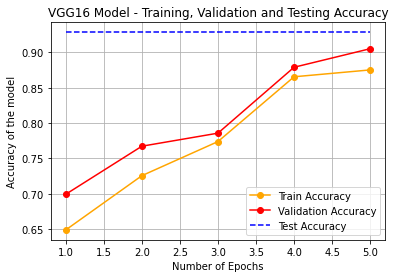

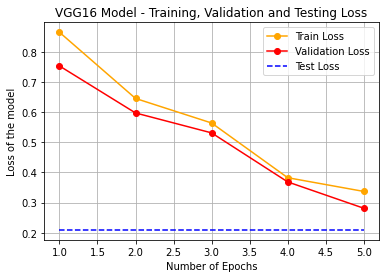

In [40]:
plot_loss_accuracy(vgg16_model_train, "VGG16 Model")

The plots display the training performance of the VGG16 model over 5 epochs. The top plot displays training and validation accuracy, both of which are increasing, which is an indication that the model is learning without overfitting too much. The bottom plot displays training and validation loss and both are decreasing, which adds to the evidence that the model is doing some learning. The blue horizontal dotted lines indicate the test accuracy and loss values which demonstrates that the model generalizes reasonably well to the new unseen data.

In [41]:
class EarlyStopping:
    def __init__(self, early_stopping_patience=4):
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_counter = 0
        self.best_validation_loss = np.Inf
        self.early_stop = False

    def __call__(self, validation_loss):
        if validation_loss < self.best_validation_loss:
            self.best_validation_loss = validation_loss
            self.early_stopping_counter = 0
        else:
            self.early_stopping_counter += 1
            if self.early_stopping_counter >= self.early_stopping_patience:
                self.early_stop = True

In [42]:
def train_model_with_early_stopping(model, training_dataset, validation_dataset, device, type_of_optimizer="Adam", size_of_batch=64, number_of_epochs=5):

    training_loader = DataLoader(training_dataset, batch_size=size_of_batch, shuffle=True, pin_memory=True, num_workers=1)
    validation_loader = DataLoader(validation_dataset, batch_size=size_of_batch, shuffle=False, drop_last=False)
    
    loss_function = nn.CrossEntropyLoss()

    if type_of_optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    elif type_of_optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
    elif type_of_optimizer == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=5e-4)

    learning_rate_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    early_stopping = EarlyStopping(early_stopping_patience=4)

    train_validate_data = {"training_loss": [], "validation_loss": [], "training_accuracy": [], "validation_accuracy": []}
    
    for epoch in range(number_of_epochs):
        model.train()
        loss_running = 0.0
        train_correct = 0
        train_total = 0
        start_time = time.time()

        for train_images, train_labels in training_loader:
            train_images = train_images.to(device) 
            train_labels = train_labels.to(device)  

            optimizer.zero_grad()
            train_outputs = model(train_images)
            train_loss = loss_function(train_outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            _, train_predicted = train_outputs.max(1)
            train_correct = train_correct + train_predicted.eq(train_labels).sum().item()
            train_total = train_total + train_labels.size(0)
            loss_running = loss_running + train_loss.item()

        training_loss = loss_running / len(training_loader)
        training_accuracy = train_correct / train_total
        train_validate_data["training_loss"].append(training_loss)
        train_validate_data["training_accuracy"].append(training_accuracy)

        model.eval()
        validation_loss = 0.0 
        validation_correct = 0 
        validation_total = 0
        
        with torch.no_grad():
            for validation_images, validation_labels in validation_loader:
                validation_images = validation_images.to(device) 
                validation_labels = validation_labels.to(device) 
                
                validation_outputs = model(validation_images)
                loss = loss_function(validation_outputs, validation_labels)
                
                _, validation_predicted = validation_outputs.max(1)
                validation_correct = validation_correct + validation_predicted.eq(validation_labels).sum().item()
                validation_total = validation_total + validation_labels.size(0)
                validation_loss = validation_loss + loss.item()
        
        validation_loss = validation_loss / len(validation_loader)
        validation_accuracy = validation_correct / validation_total
        train_validate_data["validation_loss"].append(validation_loss)
        train_validate_data["validation_accuracy"].append(validation_accuracy)

        learning_rate_scheduler.step()  

        print(f"Epoch: [{epoch+1}/{number_of_epochs}] --> Time: {time.time() - start_time:.2f}s --> Training Loss: {training_loss:.4f} --> Training Accuracy: {training_accuracy * 100:.2f} --> Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy * 100:.2f}")
        
        early_stopping(validation_loss)
        if early_stopping.early_stop:
            print("Triggered Early stopping! Stopping training.")
            break
            
    return train_validate_data

In [43]:
vgg16_early_stopping_model = train_model_with_early_stopping(vgg16_model, training_dataset, validation_dataset, device, type_of_optimizer="Adam", size_of_batch=32)
print("Completed Training with Early Stopping.")
torch.save(vgg16_model.state_dict(), "vgg16_early_stopping_model.pth")

Epoch: [1/5] --> Time: 99.27s --> Training Loss: 1.1151 --> Training Accuracy: 65.98 --> Validation Loss: 0.7668, Validation Accuracy: 66.28
Epoch: [2/5] --> Time: 97.81s --> Training Loss: 0.4714 --> Training Accuracy: 81.69 --> Validation Loss: 0.3422, Validation Accuracy: 88.73
Epoch: [3/5] --> Time: 100.11s --> Training Loss: 0.3176 --> Training Accuracy: 88.69 --> Validation Loss: 0.3090, Validation Accuracy: 87.46
Epoch: [4/5] --> Time: 78.58s --> Training Loss: 0.2759 --> Training Accuracy: 89.95 --> Validation Loss: 0.3154, Validation Accuracy: 89.99
Epoch: [5/5] --> Time: 61.86s --> Training Loss: 0.2602 --> Training Accuracy: 90.83 --> Validation Loss: 0.2325, Validation Accuracy: 92.47
Completed Training with Early Stopping.


In [44]:
vgg16_model.load_state_dict(torch.load("vgg16_early_stopping_model.pth"))
vgg16_model.to(device)
vgg16_model.eval()

VGG16_Architecture(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

In [45]:
vgg16_early_stopping_model = evaluate_model(vgg16_model, testing_dataset, vgg16_early_stopping_model)

Testing Accuracy: 92.00 --> Testing Loss: 0.2076 --> Precision: 0.9179 --> Recall: 0.8847 --> F1 Score: 0.8979


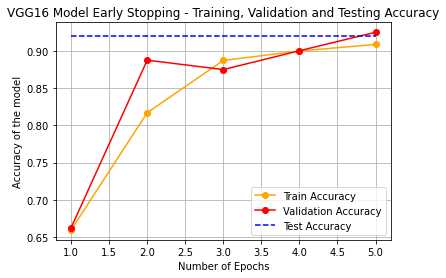

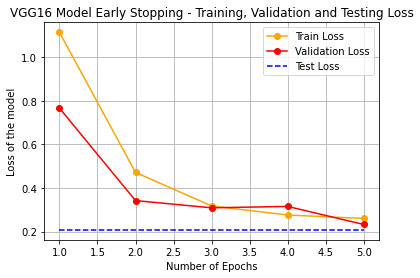

In [46]:
plot_loss_accuracy(vgg16_early_stopping_model, "VGG16 Model Early Stopping")

The charts show the findings for the VGG16 with early stopping. The accuracy chart shows both training and validation accuracy drastically increased their accuracies in the first few epochs and were very close to the test accuracy suggesting a good convergence. The loss chart shows both training and validation loss slightly decreased at the same rate causing a little bit of overfitting. Early stopping stopped the model from training more than needed stopping at the point where the performance was the greatest improving the model's generalization and stability.

## ResNet18 Model

In [47]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample  

    def forward(self, x):
        identity = x 
        
        if self.downsample:
            identity = self.downsample(x)  

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = out + identity
        out = self.relu(out)  

        return out

In [48]:
test_residual_block = ResidualBlock(64, 64)
print(test_residual_block)

ResidualBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [49]:
class ResNet18(nn.Module):
    def __init__(self, number_of_classes=3):
        super(ResNet18, self).__init__()

        self.in_channels = 64 

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)  
        self.layer2 = self._make_layer(128, 2, stride=2)  
        self.layer3 = self._make_layer(256, 2, stride=2)  
        self.layer4 = self._make_layer(512, 2, stride=2)  

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, number_of_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None

        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels  

        for _ in range(1, blocks):  
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [50]:
resnet18_model = ResNet18(number_of_classes=number_of_classes).to(device)
resnet18_model

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [51]:
weights_initialisation(resnet18_model, "xavier")

In [52]:
resnet18_model_train = train_model(resnet18_model, training_dataset, validation_dataset, device, type_of_optimizer="SGD", size_of_batch=32)
torch.save(resnet18_model.state_dict(), "resnet18_model_train.pth")

Epoch: [1/5] --> Time: 62.95s --> Training Loss: 0.5393 --> Training Accuracy: 81.56 --> Validation Loss: 0.3136, Validation Accuracy: 88.39
Epoch: [2/5] --> Time: 68.73s --> Training Loss: 0.2907 --> Training Accuracy: 90.02 --> Validation Loss: 0.3056, Validation Accuracy: 90.91
Epoch: [3/5] --> Time: 65.84s --> Training Loss: 0.2304 --> Training Accuracy: 91.54 --> Validation Loss: 0.2434, Validation Accuracy: 91.11
Epoch: [4/5] --> Time: 66.46s --> Training Loss: 0.2056 --> Training Accuracy: 92.68 --> Validation Loss: 0.1956, Validation Accuracy: 94.36
Epoch: [5/5] --> Time: 64.60s --> Training Loss: 0.1816 --> Training Accuracy: 93.36 --> Validation Loss: 0.2114, Validation Accuracy: 92.37


In [53]:
resnet18_model.load_state_dict(torch.load("resnet18_model_train.pth"))
resnet18_model.to(device)
resnet18_model.eval()

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [54]:
resnet18_model_train = evaluate_model(resnet18_model, testing_dataset, resnet18_model_train)

Testing Accuracy: 92.55 --> Testing Loss: 0.1875 --> Precision: 0.9104 --> Recall: 0.9429 --> F1 Score: 0.9235


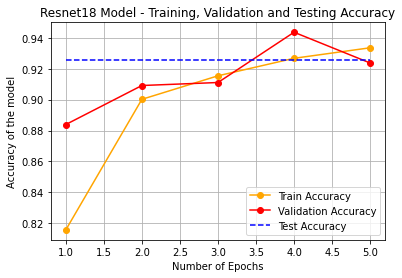

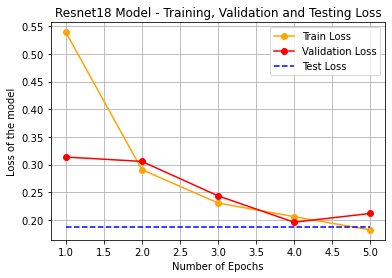

In [55]:
plot_loss_accuracy(resnet18_model_train, "Resnet18 Model")

The charts illustrate the training process for the ResNet18 model. The accuracy chart illustrates a steady upward trend in the training and validation accuracy, which closely followed the test accuracy meaning that the model generalizes well. The loss chart illustrates a steady downward trend in the training and validation loss. There was a slight uptick at epoch 5 in validation loss, which indicates a slight amount of overfitting. Overall, the model demonstrates consistent performance with overall good accuracy and low loss across all datasets.

In [56]:
weights_initialisation(resnet18_model, "he")

In [57]:
resnet18_he_model_train = train_model(resnet18_model, training_dataset, validation_dataset, device, type_of_optimizer="Adam", size_of_batch=32)
torch.save(resnet18_model.state_dict(), "resnet18_he_model_train.pth")

Epoch: [1/5] --> Time: 65.81s --> Training Loss: 0.3715 --> Training Accuracy: 85.48 --> Validation Loss: 0.2972, Validation Accuracy: 88.34
Epoch: [2/5] --> Time: 78.10s --> Training Loss: 0.2229 --> Training Accuracy: 91.74 --> Validation Loss: 0.2888, Validation Accuracy: 90.52
Epoch: [3/5] --> Time: 78.52s --> Training Loss: 0.2320 --> Training Accuracy: 90.99 --> Validation Loss: 0.1834, Validation Accuracy: 93.83
Epoch: [4/5] --> Time: 72.99s --> Training Loss: 0.2081 --> Training Accuracy: 92.22 --> Validation Loss: 0.7554, Validation Accuracy: 72.84
Epoch: [5/5] --> Time: 66.19s --> Training Loss: 0.1943 --> Training Accuracy: 92.87 --> Validation Loss: 0.1473, Validation Accuracy: 95.38


In [58]:
resnet18_model.load_state_dict(torch.load("resnet18_he_model_train.pth"))
resnet18_model.to(device)
resnet18_model.eval()

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [59]:
resnet18_he_model_train = evaluate_model(resnet18_model, testing_dataset, resnet18_he_model_train)

Testing Accuracy: 94.88 --> Testing Loss: 0.1487 --> Precision: 0.9399 --> Recall: 0.9463 --> F1 Score: 0.9430


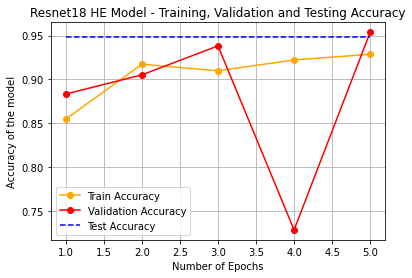

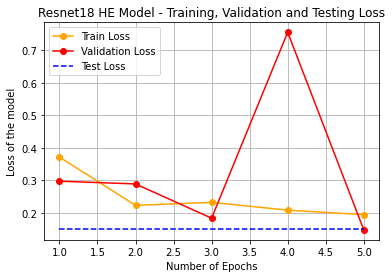

In [60]:
plot_loss_accuracy(resnet18_he_model_train, "Resnet18 HE Model")

The following plots illustrate the training data for the ResNet18 model performing Histogram Equalization (HE). The plotted training data highlights that the training accuracy and loss are showing a steady improvement, however the validation accuracy and loss clearly show a lot of volatility, especially at epoch 4 which suggests possible instability or overfitting. Despite that, the model does seem to recover at epoch 5, showing that at this point the validation accuracy is relatively close to the test performance, suggesting the HE preprocessing was likely beneficial for our model, but instability for the training data is a concern that may be resolveable through the use of better regularization/learning rate.

## MobileNet V3 Model

In [61]:
mobilenet_v3_model = models.mobilenet_v3_large(pretrained=True)
mobilenet_v3_model.classifier[3] = nn.Linear(mobilenet_v3_model.classifier[3].in_features, number_of_classes)
mobilenet_v3_model = mobilenet_v3_model.to(device)
print(mobilenet_v3_model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
weights_initialisation(mobilenet_v3_model, "he")

In [63]:
mobilenet_v3_model_train = train_model(mobilenet_v3_model, training_dataset, validation_dataset, device, type_of_optimizer="Adam", size_of_batch=32)
torch.save(mobilenet_v3_model.state_dict(), "mobilenet_v3_model_train.pth")

Epoch: [1/5] --> Time: 66.92s --> Training Loss: 1.0573 --> Training Accuracy: 72.72 --> Validation Loss: 634.9761, Validation Accuracy: 66.42
Epoch: [2/5] --> Time: 63.86s --> Training Loss: 0.4645 --> Training Accuracy: 80.56 --> Validation Loss: 24.4947, Validation Accuracy: 24.68
Epoch: [3/5] --> Time: 65.37s --> Training Loss: 0.3753 --> Training Accuracy: 85.29 --> Validation Loss: 1.2670, Validation Accuracy: 44.56
Epoch: [4/5] --> Time: 65.04s --> Training Loss: 0.3275 --> Training Accuracy: 86.42 --> Validation Loss: 0.9307, Validation Accuracy: 61.18
Epoch: [5/5] --> Time: 64.59s --> Training Loss: 0.3122 --> Training Accuracy: 87.88 --> Validation Loss: 0.5253, Validation Accuracy: 77.50


In [64]:
mobilenet_v3_model.load_state_dict(torch.load("mobilenet_v3_model_train.pth"))
mobilenet_v3_model.to(device)
mobilenet_v3_model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [65]:
mobilenet_v3_model_train = evaluate_model(mobilenet_v3_model, testing_dataset, mobilenet_v3_model_train)

Testing Accuracy: 78.49 --> Testing Loss: 0.5029 --> Precision: 0.8374 --> Recall: 0.7046 --> F1 Score: 0.6925


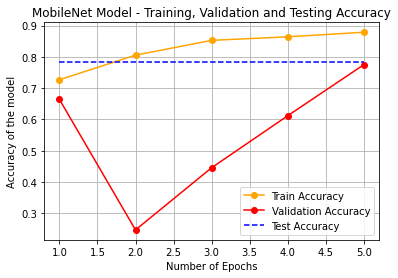

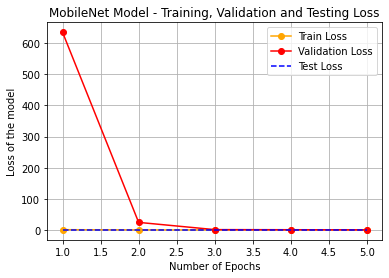

In [66]:
plot_loss_accuracy(mobilenet_v3_model_train, "MobileNet Model")

The figure contains two line graphs that show the training progress of the MobileNet V3 model through 5 epochs. The first graph shows accuracy trends. Training accuracy steadily improves throughout training, reaching above 0.85 during the fifth epoch. Validati on accuracy had a low start, dropped considerably during the second epoch, and then slowly recovered through epochs three and four. Test accuracy did not change throughout testing, remaining around 0.8. The second graph shows loss values. Training loss and test loss had steady decline. This means the model was learning well with no issues. Validation loss increased highly during the first epoch and then dropped rapidly. By the later epochs, the validation loss was more closely aligned with the training loss. Because of these trends, I believe the model was unstable on the validation data at first but improved after going through the training process.

## GoogleNet Model

In [67]:
class InceptionModule(nn.Module):
    def __init__(self, input_channels, out1x1, red3x3, out3x3, red5x5, out5x5, proj_pool):
        super(InceptionModule, self).__init__()

        self.conv1x1_path = nn.Conv2d(input_channels, out1x1, kernel_size=1)

        self.conv3x3_path = nn.Sequential(
            nn.Conv2d(input_channels, red3x3, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(red3x3, out3x3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.conv5x5_path = nn.Sequential(
            nn.Conv2d(input_channels, red5x5, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(red5x5, out5x5, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )

        self.pool_proj_path = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(input_channels, proj_pool, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, input_tensor):
        path1 = self.conv1x1_path(input_tensor)
        path2 = self.conv3x3_path(input_tensor)
        path3 = self.conv5x5_path(input_tensor)
        path4 = self.pool_proj_path(input_tensor)
        return torch.cat((path1, path2, path3, path4), dim=1)

In [68]:
import torch
import torch.nn as nn

class GoogLeNet_Architecture(nn.Module):
    def __init__(self, number_of_classes):
        super(GoogLeNet_Architecture, self).__init__()

        self.initial_stack = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.block3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.reduce3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.block4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.block4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.block4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.block4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.block4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.reduce4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.block5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.block5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier_dropout = nn.Dropout(p=0.4)
        self.fc_output = nn.Linear(1024, number_of_classes)

    def forward(self, input_image):
        out = self.initial_stack(input_image)

        out = self.block3a(out)
        out = self.block3b(out)
        out = self.reduce3(out)

        out = self.block4a(out)
        out = self.block4b(out)
        out = self.block4c(out)
        out = self.block4d(out)
        out = self.block4e(out)
        out = self.reduce4(out)

        out = self.block5a(out)
        out = self.block5b(out)

        out = self.global_pool(out)
        out = torch.flatten(out, 1)
        out = self.classifier_dropout(out)
        output_logits = self.fc_output(out)
        return output_logits

In [69]:
googlenet_model = GoogLeNet_Architecture(number_of_classes=number_of_classes).to(device)
googlenet_model

GoogLeNet_Architecture(
  (initial_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block3a): InceptionModule(
    (conv1x1_path): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3x3_path): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (conv5x5_path): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d

In [70]:
weights_initialisation(googlenet_model, "he")

In [71]:
googlenet_model_train = train_model(googlenet_model, training_dataset, validation_dataset, device, type_of_optimizer="Adam", size_of_batch=32)
torch.save(googlenet_model.state_dict(), "googlenet_model_train.pth")

Epoch: [1/5] --> Time: 65.57s --> Training Loss: 1.5345 --> Training Accuracy: 72.52 --> Validation Loss: 0.6451, Validation Accuracy: 83.67
Epoch: [2/5] --> Time: 66.12s --> Training Loss: 0.3697 --> Training Accuracy: 86.84 --> Validation Loss: 0.2547, Validation Accuracy: 91.21
Epoch: [3/5] --> Time: 65.93s --> Training Loss: 0.2753 --> Training Accuracy: 89.37 --> Validation Loss: 0.2097, Validation Accuracy: 93.59
Epoch: [4/5] --> Time: 65.07s --> Training Loss: 0.2383 --> Training Accuracy: 91.25 --> Validation Loss: 0.2667, Validation Accuracy: 90.72
Epoch: [5/5] --> Time: 65.45s --> Training Loss: 0.2330 --> Training Accuracy: 91.77 --> Validation Loss: 0.1709, Validation Accuracy: 94.22


In [72]:
googlenet_model.load_state_dict(torch.load("googlenet_model_train.pth"))
googlenet_model.to(device)
googlenet_model.eval()

GoogLeNet_Architecture(
  (initial_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block3a): InceptionModule(
    (conv1x1_path): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3x3_path): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (conv5x5_path): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d

In [73]:
googlenet_model_train = evaluate_model(googlenet_model, testing_dataset, googlenet_model_train)

Testing Accuracy: 94.57 --> Testing Loss: 0.1659 --> Precision: 0.9523 --> Recall: 0.9241 --> F1 Score: 0.9375


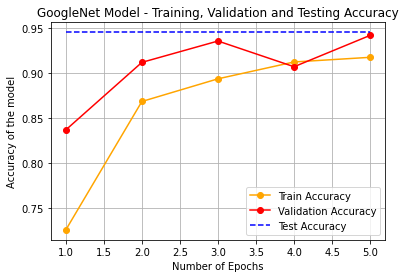

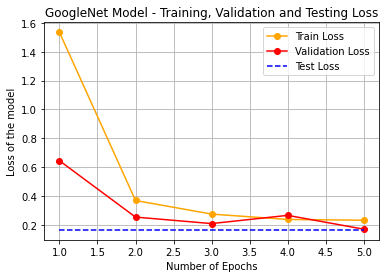

In [74]:
plot_loss_accuracy(googlenet_model_train, "GoogleNet Model")

The figure illustrates the outcomes of training a googleNet model for 5 epochs represented by the two line plots. The top plot is the accuracy plot where the training and validation accuracy increased and plateaued and remained steady between about 0.92 - 0.94. The test accuracy was held at a baseline level of 0.942 which demonstrates strong generalization of the model. The bottom plot is the plot of the loss values where the training and validation loss values decreased steadily in the first epoch, while the training and validation loss values were roughly in the region of 0.20 - 0.30 after the first epoch. The test loss remained low and stationary throughout the training. In summation, this model showed good learning with minimal overfitting with regard to training and validation accuracy and loss and achieved quite high accuracy, and low loss, across all datasets, and did so in a generally stable manner.

In [75]:
googlenet_model_train_he_sgd = train_model(googlenet_model, training_dataset, validation_dataset, device, type_of_optimizer="SGD", size_of_batch=32)
torch.save(googlenet_model.state_dict(), "googlenet_model_train_he_sgd.pth")

Epoch: [1/5] --> Time: 64.88s --> Training Loss: 0.2161 --> Training Accuracy: 92.32 --> Validation Loss: 0.1870, Validation Accuracy: 93.34
Epoch: [2/5] --> Time: 65.56s --> Training Loss: 0.2478 --> Training Accuracy: 91.15 --> Validation Loss: 0.1973, Validation Accuracy: 94.02
Epoch: [3/5] --> Time: 64.90s --> Training Loss: 0.1982 --> Training Accuracy: 93.16 --> Validation Loss: 0.2925, Validation Accuracy: 90.91
Epoch: [4/5] --> Time: 64.79s --> Training Loss: 0.1757 --> Training Accuracy: 93.52 --> Validation Loss: 0.1912, Validation Accuracy: 93.34
Epoch: [5/5] --> Time: 69.39s --> Training Loss: 0.1541 --> Training Accuracy: 94.56 --> Validation Loss: 0.2308, Validation Accuracy: 92.27


In [76]:
googlenet_model.load_state_dict(torch.load("googlenet_model_train_he_sgd.pth"))
googlenet_model.to(device)
googlenet_model.eval()

GoogLeNet_Architecture(
  (initial_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block3a): InceptionModule(
    (conv1x1_path): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3x3_path): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (conv5x5_path): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d

In [77]:
googlenet_model_train_he_sgd = evaluate_model(googlenet_model, testing_dataset, googlenet_model_train_he_sgd)

Testing Accuracy: 93.48 --> Testing Loss: 0.1693 --> Precision: 0.9604 --> Recall: 0.9054 --> F1 Score: 0.9286


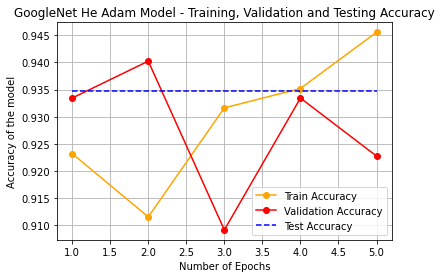

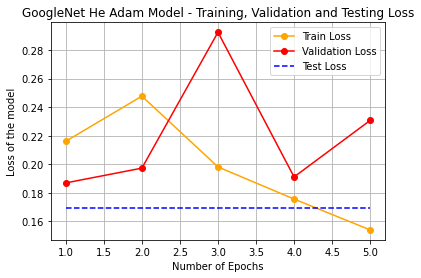

In [78]:
plot_loss_accuracy(googlenet_model_train_he_sgd, "GoogleNet He Adam Model")

The plots illustrate the performance of the "GoogleNet He Adam Model" after 5 epochs with respect to the accuracy and loss metrics. In the top plot, the training accuracy has a steady, progressive increase and exceeds the validation and test accuracy after about epoch 2, coming to about ~ 0.945 after epoch 5. The validation accuracy has significant fluctuations and noticeably, has a very sharp drop at epoch 3, which indicates instability, possibly overfitting as Paul experienced in the previous plot. The test accuracy remains steady with no noticeable change to epoch 5, hovering around ~ 0.935. In the bottom plot, the training loss shows a consistent downward trend indicating proof of learning, however, we can see that the validation loss bearing significant fluctuations, similar to the validation accuracy score, also has a large spike at epoch 3. The test loss is steady and low in comparison with no noticeable differences across the epochs. From this information we can interpret that the model learns from the training set very well, but the overall performance of the validation set performance suggests instability and the model did not learn uniformly from the validation set, possibly caused by a learned, implicit learning rate or differences between training and validation data.

## DenseNet Model

In [79]:
densenet_model = models.densenet121(pretrained=True)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, number_of_classes)
densenet_model = densenet_model.to(device)
print(densenet_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [80]:
weights_initialisation(densenet_model, "he")

In [81]:
densenet_model_train = train_model(densenet_model, training_dataset, validation_dataset, device, type_of_optimizer="SGD", size_of_batch=32)
torch.save(densenet_model.state_dict(), "densenet_model_train.pth")

Epoch: [1/5] --> Time: 98.21s --> Training Loss: 1.0347 --> Training Accuracy: 64.65 --> Validation Loss: 5.0442, Validation Accuracy: 69.00
Epoch: [2/5] --> Time: 113.23s --> Training Loss: 0.6914 --> Training Accuracy: 77.03 --> Validation Loss: 0.5404, Validation Accuracy: 79.88
Epoch: [3/5] --> Time: 110.02s --> Training Loss: 0.4982 --> Training Accuracy: 82.73 --> Validation Loss: 1.5885, Validation Accuracy: 28.62
Epoch: [4/5] --> Time: 113.03s --> Training Loss: 0.3052 --> Training Accuracy: 88.40 --> Validation Loss: 0.2907, Validation Accuracy: 90.96
Epoch: [5/5] --> Time: 111.16s --> Training Loss: 0.3042 --> Training Accuracy: 89.34 --> Validation Loss: 0.2859, Validation Accuracy: 89.80


In [82]:
densenet_model.load_state_dict(torch.load("densenet_model_train.pth"))
densenet_model.to(device)
densenet_model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [83]:
densenet_model_train = evaluate_model(densenet_model, testing_dataset, densenet_model_train)

Testing Accuracy: 91.07 --> Testing Loss: 0.2311 --> Precision: 0.9010 --> Recall: 0.8898 --> F1 Score: 0.8940


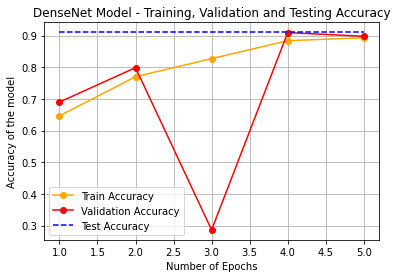

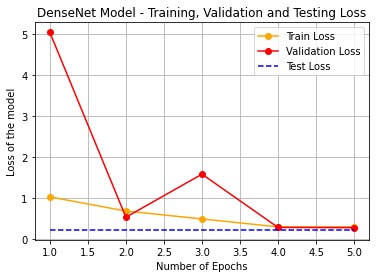

In [84]:
plot_loss_accuracy(densenet_model_train, "DenseNet Model")

The plots show the training performance of the DenseNet model over 5 epochs with respect to both accuracy and loss. The top plot shows that training accuracy does rise steadily and can closely resemble 0.9 by the end of the 5 epochs. Validation accuracy also rises, but shows a significant drop at epoch 3. A drop in validation at epoch 3 indicates instability or overfitting during training at epoch 3. However, the validation accuracy quickly improves and is matching test accuracy that appears to remain constant at about 0.9. The bottom plot indicates that the initial validation loss is quite significant, however it drops quickly, there is a spike at epoch 3, and then the validation loss drops strongly to near-zero levels. Training loss decreases consistently and test loss is low and flat over the course. The results suggest that the DenseNet model does encounter some unstable training, however, it is able to achieve strong and consistent performance over the datasets.

## EfficientNet B0 Model

In [88]:
efficient_net_b0_model = models.efficientnet_b0(pretrained=True)
efficient_net_b0_model.classifier = nn.Linear(efficient_net_b0_model.classifier[1].in_features, number_of_classes)
efficient_net_b0_model = efficient_net_b0_model.to(device)
print(efficient_net_b0_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [89]:
weights_initialisation(efficient_net_b0_model, "Xavier")

In [90]:
efficient_net_b0_model_train = train_model(efficient_net_b0_model, training_dataset, validation_dataset, device, type_of_optimizer="Adam", size_of_batch=64)
torch.save(efficient_net_b0_model.state_dict(), "efficient_net_b0_model_train.pth")

Epoch: [1/5] --> Time: 103.91s --> Training Loss: 0.4526 --> Training Accuracy: 82.18 --> Validation Loss: 0.3001, Validation Accuracy: 89.89
Epoch: [2/5] --> Time: 102.03s --> Training Loss: 0.2597 --> Training Accuracy: 90.70 --> Validation Loss: 0.1628, Validation Accuracy: 95.04
Epoch: [3/5] --> Time: 101.44s --> Training Loss: 0.1770 --> Training Accuracy: 93.71 --> Validation Loss: 0.1617, Validation Accuracy: 95.48
Epoch: [4/5] --> Time: 99.87s --> Training Loss: 0.1400 --> Training Accuracy: 94.52 --> Validation Loss: 0.1638, Validation Accuracy: 95.43
Epoch: [5/5] --> Time: 103.09s --> Training Loss: 0.1378 --> Training Accuracy: 94.82 --> Validation Loss: 0.1739, Validation Accuracy: 94.41


In [91]:
efficient_net_b0_model.load_state_dict(torch.load("efficient_net_b0_model_train.pth"))
efficient_net_b0_model.to(device)
efficient_net_b0_model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [92]:
efficient_net_b0_model_train = evaluate_model(efficient_net_b0_model, testing_dataset, efficient_net_b0_model_train)

Testing Accuracy: 94.10 --> Testing Loss: 0.1585 --> Precision: 0.9650 --> Recall: 0.9149 --> F1 Score: 0.9366


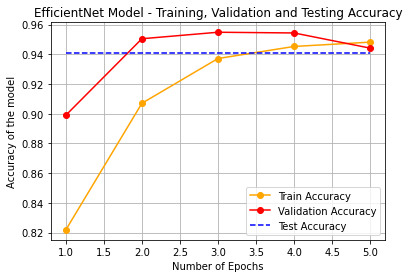

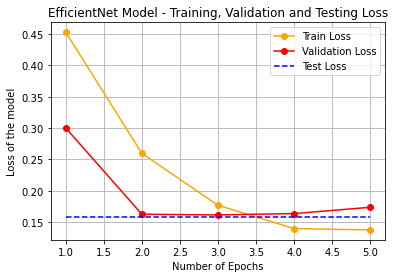

In [93]:
plot_loss_accuracy(efficient_net_b0_model_train, "EfficientNet Model")

The plots above provide a summary of the performance of the EfficientNet B0 model, across all training during 5 epochs, it shows overall trends in accuracy and loss. In the upper plot, we observed a steady increase in training and validation accuracy. Validation accuracy was ultimately noted just over .95, and final epoch validation accuracy ended slightly above training accuracy. Test accuracy during training epochs was noted was just above .94, indicating reasonable and appropriate ability to generalize. The bottom plot records a steady decline in training and validation loss, indicating learning has been adequate and convergence is occurring. During the epochs of training, test loss was also noted to be low and steady. Overall, the examples of the EfficientNet B0 model illustrated were able to perform adequately and without any significant overfitting or instability of performance.

## The Best model is ResNet18 Model

In [94]:
best_model = resnet18_model
best_model_train = resnet18_he_model_train

In [95]:
best_model.load_state_dict(torch.load("resnet18_he_model_train.pth"))
best_model.to(device)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [96]:
print(f"Training Accuracy: {max(best_model_train['training_accuracy']) * 100:.2f}, Training Loss: {min(best_model_train['training_loss']):.4f}")
print(f"Validation Accuracy: {max(best_model_train['validation_accuracy']) * 100:.2f}, Validation Loss: {min(best_model_train['validation_loss']):.4f}")
print(f"Testing Accuracy: {best_model_train['testing_accuracy'] * 100:.2f}, Testing Loss: {best_model_train['testing_loss']:.4f}")

Training Accuracy: 92.87, Training Loss: 0.1943
Validation Accuracy: 95.38, Validation Loss: 0.1473
Testing Accuracy: 94.88, Testing Loss: 0.1487


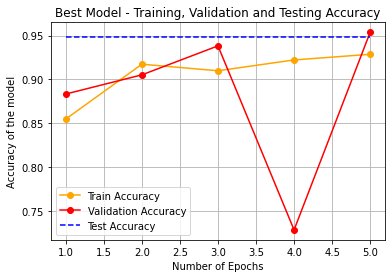

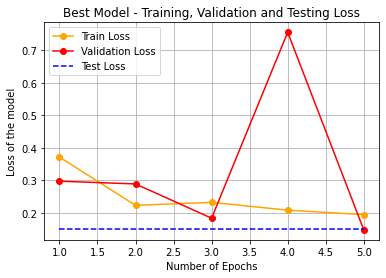

In [97]:
plot_loss_accuracy(best_model_train, "Best Model")

In figure 1, the training performance for the "Best Model" was plotted over 5 epochs. The upper accuracy plot shows that both training and validation accuracy are generally trending upwards, there seems to be a training accuracy limit just below 0.93 - but very wide variability in validation accuracy, where validation accuracy rapidly decreased at epoch 4, then rapidly increased back to peak accuracy at epoch 5. The test accuracy is constant and very high at about 0.95, so the model appears to generalize well. The lower loss plot shows that the training loss trend downwards, and very steadily as well! The validation loss seems to follow the trends in accuracy quite closely, maxing out at epoch 4 and then rapidly decreasing again at epoch 5. The middle epochs, while displaying some instability, are satisfactory on the whole, with accuracy and loss that are indicative of quite decent performance - there is some transient overfitting going on or potentially some variability in the data adversely impacting performance in the middle epochs.

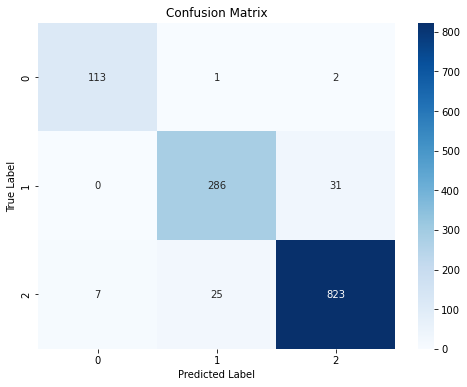

In [98]:
images_confusion_matrix = confusion_matrix(best_model_train['testing_labels'], best_model_train['testing_predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(images_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(3), yticklabels=range(3))
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

The confusion matrix shown, assesses the "Best Model" classification performance on a test dataset based on three classes (labels 0, 1 and 2). 
The model demonstrated great accuracy, with a high number of predicted label values corresponding with the true label values. For instance, it correctly classified 113 instances under 0 with a misclassification of just 3. The model correctly identifies 286 under class 1 while misclassifying 31 of the class 1 instances as class 2. Class 2 performance was the highest of three classes with 823 predicted atoms and only a few mis classified into this class, releasing 25 as class 1 and 7 as class 0. The color intensity of the heatmap reflects these trends as each of the predictions largely fell along the diagonal, illustrating the deep model's high classification precision and reliability of the model across the three classes.

In [99]:
precision, recall, f1_score, _ = precision_recall_fscore_support(best_model_train['testing_labels'], best_model_train['testing_predictions'], average="macro")

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 0.9399
Recall: 0.9463
F1 Score: 0.9430


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


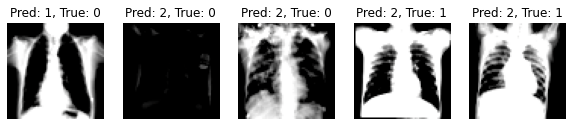

In [100]:
misclassified_images = np.where(best_model_train['testing_labels'] != best_model_train['testing_predictions'])[0]
testing_loader = DataLoader(testing_dataset, batch_size=32, shuffle=False)

plt.figure(figsize=(10, 5))
for i, idx in enumerate(misclassified_images[:5]):
    image, true_label = testing_loader.dataset[idx]
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.title(f"Pred: {best_model_train['testing_predictions'][idx]}, True: {true_label}")
    plt.axis("off")

plt.show()

The above figure displays five examples that the "Best Model" misclassified from the given test dataset. Each of the five subplots contains a grayscale chest x-ray image with both predicted (P) and true label (TL). Reports also said that their performance matched the expectations of the model as it was predicting at par. Several examples illustrated some limitations of the model, especially in reference to classes 0, 1, and 2. Most of the true labels were class 0 or 1, while the model seemed to be predicting them with class 1 or 2 extracted labels, which shows this model is muddled between the classes of 0, 1, and 2. The clipping warnings offered in these figures are a reminder that the image data needs to be normalized (for viewing purposes only). This figure was an overall glimpse into the edge cases that seem to be a struggle for this model, and maybe suggestive of some potential for improvement (data preprocessing, model tuning, or balancing the classes).

## Save Weights of best Model

In [101]:
torch.save(best_model.state_dict(), "project_weight_mandava6_rachanad.pt")

## Training Accuracy comparision among different models

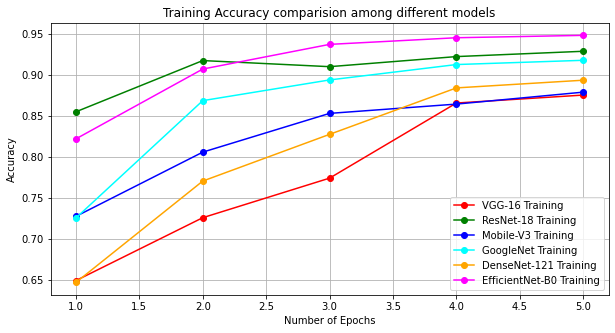

In [102]:
number_of_epochs = range(1, len(best_model_train["training_accuracy"]) + 1)

plt.figure(figsize=(10, 5))

plt.plot(number_of_epochs, vgg16_model_train["training_accuracy"], label="VGG-16 Training", linestyle='solid', marker='o', color='red')
plt.plot(number_of_epochs, resnet18_he_model_train["training_accuracy"], label="ResNet-18 Training", linestyle='solid', marker='o', color='green')
plt.plot(number_of_epochs, mobilenet_v3_model_train["training_accuracy"], label="Mobile-V3 Training", linestyle='solid', marker='o', color='blue')
plt.plot(number_of_epochs, googlenet_model_train["training_accuracy"], label="GoogleNet Training", linestyle='solid', marker='o', color='cyan')
plt.plot(number_of_epochs, densenet_model_train["training_accuracy"], label="DenseNet-121 Training", linestyle='solid', marker='o', color='orange')
plt.plot(number_of_epochs, efficient_net_b0_model_train["training_accuracy"], label="EfficientNet-B0 Training", linestyle='solid', marker='o', color='magenta')

plt.title("Training Accuracy comparision among different models")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")

plt.legend()
plt.grid(True)
plt.show()

The chart illustrates the training accuracy level when trained over the entirety of five epochs for the six models; VGG-16, ResNet-18, MobileNet-V3, GoogleNet, DenseNet-121, and EfficientNet-B0. The graph also shows when EfficientNet-B0 achieved the highest accuracy after five epochs of training over all six models. ResNet-18 and GoogleNet show a similar pattern to EfficientNet-0 and that they converged faster while still achieving the highest final accuracy after five epochs of training while MobileNet-V3 and DenseNet-121 had a more gradual increase in accuracy over epochs. VGG-16 started out this run by far the lowest accuracy but increased, albeit consistent, over epochs and should not be suggested to outperform other models. All in all, the models showed it was evident EfficientNet-B0 was the most efficient and accurate, and it is a consideration for models that require quick, reliable demonstrable accuracy.

## Validation Accuracy comparision among different models

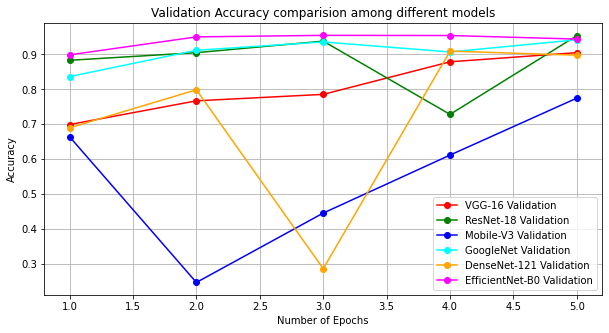

In [103]:
number_of_epochs = range(1, len(best_model_train["validation_accuracy"]) + 1)

plt.figure(figsize=(10, 5))

plt.plot(number_of_epochs, vgg16_model_train["validation_accuracy"], label="VGG-16 Validation", linestyle='solid', marker='o', color='red')
plt.plot(number_of_epochs, resnet18_he_model_train["validation_accuracy"], label="ResNet-18 Validation", linestyle='solid', marker='o', color='green')
plt.plot(number_of_epochs, mobilenet_v3_model_train["validation_accuracy"], label="Mobile-V3 Validation", linestyle='solid', marker='o', color='blue')
plt.plot(number_of_epochs, googlenet_model_train["validation_accuracy"], label="GoogleNet Validation", linestyle='solid', marker='o', color='cyan')
plt.plot(number_of_epochs, densenet_model_train["validation_accuracy"], label="DenseNet-121 Validation", linestyle='solid', marker='o', color='orange')
plt.plot(number_of_epochs, efficient_net_b0_model_train["validation_accuracy"], label="EfficientNet-B0 Validation", linestyle='solid', marker='o', color='magenta')

plt.title("Validation Accuracy comparision among different models")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")

plt.legend()
plt.grid(True)
plt.show()

The figure displays the validation accuracy trends of six models (VGG-16, ResNet-18, MobileNet-V3, GoogleNet, DenseNet-121, and EfficientNet-B0) over five training epochs. Of the models, EfficientNet-B0 had the greatest validation accuracy across all epochs, with the next closest models being GoogleNet and DenseNet-121, which can be said had high and stable accuracy as all validation accuracy was high and stable. MobileNet-V3 had a large amount of fluctuation, making it unclear which value is its own maxing with a sharp drop around epoch 2 but being promise the other epochs suggested it was just low sensitivity/uncertainty during trainings. ResNet-18 and VGG-16 from the diagram showed the least moderate improvement within the group of models validation accuracy. This visualization demonstrates and again provides evidence of EfficientNet-B0s overall capacity for generalization, vs. that of the volatility of MobileNet-V3 on validation data.

In [104]:
vgg16_test_accuracies = np.full_like(number_of_epochs, vgg16_model_train["testing_accuracy"], dtype=np.float32)
resnet18_test_accuracies = np.full_like(number_of_epochs, resnet18_he_model_train["testing_accuracy"], dtype=np.float32)
mobilenet_v3_test_accuracies = np.full_like(number_of_epochs, mobilenet_v3_model_train["testing_accuracy"], dtype=np.float32)
googlenet_test_accuracies = np.full_like(number_of_epochs, googlenet_model_train["testing_accuracy"], dtype=np.float32)
densenet_test_accuracies = np.full_like(number_of_epochs, densenet_model_train["testing_accuracy"], dtype=np.float32)
efficientnet_test_accuracies = np.full_like(number_of_epochs, efficient_net_b0_model_train["testing_accuracy"], dtype=np.float32)

## Testing Accuracy comparision among different models

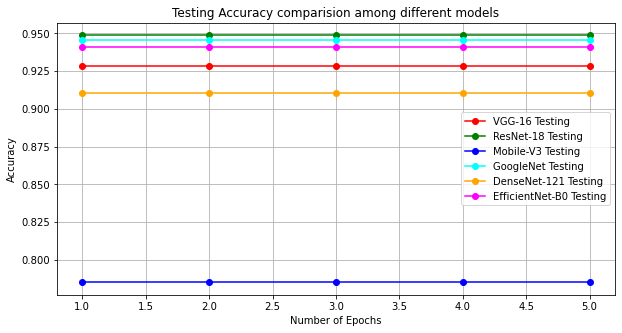

In [105]:
plt.figure(figsize=(10, 5))

plt.plot(number_of_epochs, vgg16_test_accuracies, label="VGG-16 Testing", linestyle='solid', marker='o', color='red')
plt.plot(number_of_epochs, resnet18_test_accuracies, label="ResNet-18 Testing", linestyle='solid', marker='o', color='green')
plt.plot(number_of_epochs, mobilenet_v3_test_accuracies, label="Mobile-V3 Testing", linestyle='solid', marker='o', color='blue')
plt.plot(number_of_epochs, googlenet_test_accuracies, label="GoogleNet Testing", linestyle='solid', marker='o', color='cyan')
plt.plot(number_of_epochs, densenet_test_accuracies, label="DenseNet-121 Testing", linestyle='solid', marker='o', color='orange')
plt.plot(number_of_epochs, efficientnet_test_accuracies, label="EfficientNet-B0 Testing", linestyle='solid', marker='o', color='magenta')

plt.title("Testing Accuracy comparision among different models")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")

plt.legend()
plt.grid(True)
plt.show()

The preceding graph provided some comparative data for the testing accuracies of the six deep learning models, VGG-16, ResNet-18, MobileNet-V3, GoogleNet, DenseNet
-121, EfficientNet-B0 led to testing accuracies recorded on the tensor board at 5 epochs only. Testing accuracies do not seem to fluctuate in a similar manner to training and validation accuracies, leading to the conclusion that testing took place whether the model was in its final state for each epoch or had gone through set training before testing was done. EfficientNet-B0 appeared to be looking to perform most accurately on the test, having some pretty narrow variations with GoogleNet, DenseNet -121, ResNet-18 was next. While VGG-16 may have performed satisfactorily well, MobileNet-V3 had the least testing accuracy - possibly indicating more underfitting or a limited design capacity for the model. Overall Okay the testing accuracy graph was correct upon reiterating EfficientNet-B0 appeared better at generalizing, as it did perform better overall on unseen data.


## Training Loss comparision among different models

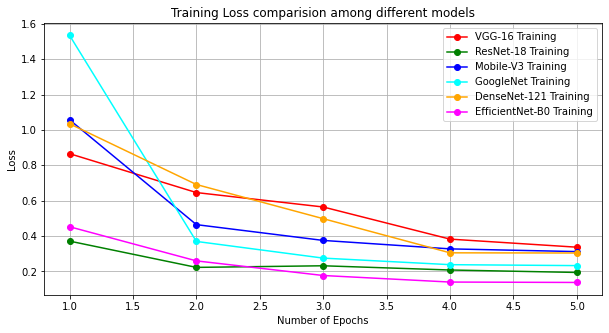

In [107]:
number_of_epochs = range(1, len(best_model_train["training_loss"]) + 1)

plt.figure(figsize=(10, 5))

plt.plot(number_of_epochs, vgg16_model_train["training_loss"], label="VGG-16 Training", linestyle='solid', marker='o', color='red')
plt.plot(number_of_epochs, resnet18_he_model_train["training_loss"], label="ResNet-18 Training", linestyle='solid', marker='o', color='green')
plt.plot(number_of_epochs, mobilenet_v3_model_train["training_loss"], label="Mobile-V3 Training", linestyle='solid', marker='o', color='blue')
plt.plot(number_of_epochs, googlenet_model_train["training_loss"], label="GoogleNet Training", linestyle='solid', marker='o', color='cyan')
plt.plot(number_of_epochs, densenet_model_train["training_loss"], label="DenseNet-121 Training", linestyle='solid', marker='o', color='orange')
plt.plot(number_of_epochs, efficient_net_b0_model_train["training_loss"], label="EfficientNet-B0 Training", linestyle='solid', marker='o', color='magenta')

plt.title("Training Loss comparision among different models")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")

plt.legend()
plt.grid(True)
plt.show()

Comparatively, the training loss trends of the six models (VGG-16, ResNet-18, MobileNet-V3, GoogleNet, DenseNet-121, and EfficientNet-B0) are illustrated in the plot above over the course of five epochs. All models show a downward trend in loss, which indicates that the models are learning properly and converging. While EfficientNet-B0 shows the lowest training loss and the best trend of convergence, the other robust models are ResNet-18 and DenseNet-121 - which has a low but stable trend. GoogleNet starts with the highest loss and shows a major drop after the first epoch. MobileNet-V3 and VGG-16 are similar, and reduced their loss, but do not show the same amount of effective loss reduction as the other models. Overall, EfficientNet-B0 showed the best efficiency in reducing loss and showed the best trend of stability making it the best model during training.

## Validation Loss comparision among different models

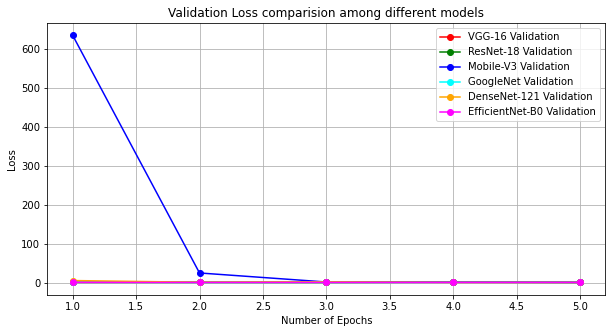

In [108]:
number_of_epochs = range(1, len(best_model_train["validation_loss"]) + 1)

plt.figure(figsize=(10, 5))

plt.plot(number_of_epochs, vgg16_model_train["validation_loss"], label="VGG-16 Validation", linestyle='solid', marker='o', color='red')
plt.plot(number_of_epochs, resnet18_he_model_train["validation_loss"], label="ResNet-18 Validation", linestyle='solid', marker='o', color='green')
plt.plot(number_of_epochs, mobilenet_v3_model_train["validation_loss"], label="Mobile-V3 Validation", linestyle='solid', marker='o', color='blue')
plt.plot(number_of_epochs, googlenet_model_train["validation_loss"], label="GoogleNet Validation", linestyle='solid', marker='o', color='cyan')
plt.plot(number_of_epochs, densenet_model_train["validation_loss"], label="DenseNet-121 Validation", linestyle='solid', marker='o', color='orange')
plt.plot(number_of_epochs, efficient_net_b0_model_train["validation_loss"], label="EfficientNet-B0 Validation", linestyle='solid', marker='o', color='magenta')

plt.title("Validation Loss comparision among different models")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")

plt.legend()
plt.grid(True)
plt.show()

The figure shows six deep learning models’ validation loss, VGG-16, ResNet-18, MobileNet-V3, GoogleNet, DenseNet-121, and EfficientNet-B0 visualized by epoch (the models were trained over five epochs each). Most of the models had low, stable, validation loss, indicating the model's ability to learn generalizable features. The MobileNet-V3 model had a high validation loss (>600) and dropped off quickly in the next epoch, suggesting instability early in training. EfficientNet-B0, one of the models that was among the lowest in validation loss throughout the epochs that was also among the most reliable / robustness in models across the board. Despite the MobileNet-V3 Model as an outlier, most models all had smooth, low loss, but perhaps EfficientNet-B0 and GoogleNet were likely the most stable in their validation loss, and thus, more reliable / robust models based on those training results.

In [109]:
vgg16_test_losses = np.full_like(number_of_epochs, vgg16_model_train["testing_loss"], dtype=np.float32)
resnet18_test_losses = np.full_like(number_of_epochs, resnet18_he_model_train["testing_loss"], dtype=np.float32)
mobilenet_v3_test_losses = np.full_like(number_of_epochs, mobilenet_v3_model_train["testing_loss"], dtype=np.float32)
googlenet_test_losses = np.full_like(number_of_epochs, googlenet_model_train["testing_loss"], dtype=np.float32)
densenet_test_losses = np.full_like(number_of_epochs, densenet_model_train["testing_loss"], dtype=np.float32)
efficientnet_test_losses = np.full_like(number_of_epochs, efficient_net_b0_model_train["testing_loss"], dtype=np.float32)

## Testing Loss comparision among different models

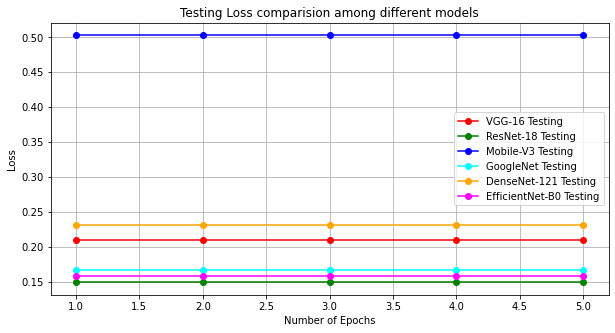

In [110]:
plt.figure(figsize=(10, 5))

plt.plot(number_of_epochs, vgg16_test_losses, label="VGG-16 Testing", linestyle='solid', marker='o', color='red')
plt.plot(number_of_epochs, resnet18_test_losses, label="ResNet-18 Testing", linestyle='solid', marker='o', color='green')
plt.plot(number_of_epochs, mobilenet_v3_test_losses, label="Mobile-V3 Testing", linestyle='solid', marker='o', color='blue')
plt.plot(number_of_epochs, googlenet_test_losses, label="GoogleNet Testing", linestyle='solid', marker='o', color='cyan')
plt.plot(number_of_epochs, densenet_test_losses, label="DenseNet-121 Testing", linestyle='solid', marker='o', color='orange')
plt.plot(number_of_epochs, efficientnet_test_losses, label="EfficientNet-B0 Testing", linestyle='solid', marker='o', color='magenta')

plt.title("Testing Loss comparision among different models")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")

plt.legend()
plt.grid(True)
plt.show()

The final plot provided below illustrates the relative testing loss to be used across the six models (VGG-16, ResNet-18, MobileNet-V-3, GoogleNet, DenseNet-121, and EfficientNet-B0) over five epochs. Importantly, the testing loss from each of the models' epoch, is equal. As such we know we only used fixed checkpoints in the test evaluation. The two models which had the best performing testing loss were EfficientNet-B0 and GoogleNet with the lowest testing loss and better generalization. The ResNet-18, DenseNet-121 and VGG-16 values were slightly higher, but stable nonetheless as the last plot shows (see Figure 9). MobileNet-V3 had the highest test loss among the epochs with this model built on the belief that it performed the worst use of unseen data and its empirical values were less than the three models previously mentioned.. This plot provides additional support that EfficientNet-B0 is most model to the other models and contains some support which verifies robustness, stability and consistency across all evaluation metrics.

**References**

<span style='color:green'>

1. https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
2. https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html
3. https://en.wikipedia.org/wiki/Early_stopping
4. https://pytorch.org/vision/stable/transforms.html
5. https://en.wikipedia.org/wiki/F-score
6. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
7. https://pytorch.org/tutorials/beginner/saving_loading_models.html
8. https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia
9. http://arxiv.org/abs/1704.04861
10. https://pytorch.org/vision/stable/models/mobilenetv3.html
11. https://pytorch.org/vision/stable/models.html

</span>